这里 我们使用普通RNN和SegRNN架构对比patch的作用

为什么要进行Patch？

我们希望收集一个长序列的信息

In [13]:
import os
os.chdir('d:/future/index_future_prediction/Index_Future_Prediction')

In [14]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import lr_scheduler, Adam, AdamW
from scipy.stats import norm, t

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [15]:
from utils.random_split import RandomSplit, CallableDataset
from utils.back_test import BackTest
from utils.hybrid_loss import HybridLoss
from utils.hybrid_decoder import HybridDecoder
from utils.prediction_recorder import PredictionRecorder
from utils.train_animator import TrainAnimator
from utils.model_train import ModelTrain
from utils.get_ohlcv import GetOHLCV

In [16]:
import tushare as ts
pro = ts.pro_api('700c1d6015ad030ff20bf310c088243da030e6b79a2a1098d58d2614')

In [17]:
assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX', 'AU.SHF', 'FU.SHF', 'JM.DCE','RB.SHF','HC.SHF', 'I.DCE', 'M.DCE', 'CF.ZCE',]
assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX']

In [18]:
seq_len = 30
pred_len = 5
train_ratio = 0.5
validation_ratio = 0.2
test_ratio = 0.02
threshold_ratio = 0.25

In [19]:
def get_random_split(train_ratio, validation_ratio, test_ratio):
    source = GetOHLCV()
    sample_date = source.get_data('M.DCE', 5, 0.3)
    date_column = sample_date['trade_date'].copy()
    total_size = len(date_column)
    train_size = int(train_ratio * total_size)
    validation_size = int(validation_ratio * total_size)
    test_size = int(test_ratio * total_size)
    random_split = np.random.randint(train_size, total_size - validation_size - test_size)
    validation_start = date_column.iloc[random_split]
    test_start = date_column.iloc[random_split+validation_size]
    test_end = date_column.iloc[random_split+validation_size+test_size]
    return validation_start, test_start, test_end

In [20]:
def get_data_set(assets_list, validation_start, test_start, test_end, seq_len, pred_len, threshold_ratio):

    source = GetOHLCV()

    train_set = None
    validation_set = None
    test_set = None
    feature_column = ['log_open','log_high','log_low','log_close','log_amount']
    label_column = ['label_return','down_prob','middle_prob','up_prob']
    
    for code in assets_list:

        data = source.get_data(code, pred_len, threshold_ratio)

        train_data = data[data['trade_date'] < validation_start].copy()
        validation_data = data[(data['trade_date'] >= validation_start) & (data['trade_date'] < test_start)].copy()
        test_data = data[(data['trade_date'] >= test_start) & (data['trade_date'] < test_end)].copy()
    
        train_feature = torch.tensor(train_data[feature_column].values, dtype = torch.float32, device = 'cuda:0')
        train_feature = train_feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(1,2)

        validation_feature = torch.tensor(validation_data[feature_column].values, dtype = torch.float32, device = 'cuda:0')
        validation_feature = validation_feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(1,2)

        test_feature = torch.tensor(test_data[feature_column].values, dtype = torch.float32, device = 'cuda:0')
        test_feature = test_feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(1,2)



        train_label = torch.tensor(train_data[label_column].values, dtype = torch.float32, device = 'cuda:0')
        train_label = train_label[seq_len-1:]

        validation_label = torch.tensor(validation_data[label_column].values, dtype = torch.float32, device = 'cuda:0')
        validation_label = validation_label[seq_len-1:]

        test_label = torch.tensor(test_data[label_column].values, dtype = torch.float32, device = 'cuda:0')
        test_label = test_label[seq_len-1:]



        if train_set == None:
            train_set = CallableDataset(train_feature, train_label)
        else:
            train_set = train_set + CallableDataset(train_feature, train_label)

        if validation_set == None:
            validation_set = CallableDataset(validation_feature, validation_label)
        else:
            validation_set = validation_set + CallableDataset(validation_feature, validation_label)
        
        if test_set == None:
            test_set = CallableDataset(test_feature, test_label)
        else:
            test_set = test_set + CallableDataset(test_feature, test_label)

    return train_set, validation_set, test_set

In [21]:
validation_start, test_start, test_end = get_random_split(train_ratio, validation_ratio, test_ratio)

In [22]:
recorder = PredictionRecorder()
animator = TrainAnimator(figsize=(12,6))

Animator data has been reset.


In [23]:
class Baseline_LSTM(nn.Module):
    """循环神经网络模型"""
    def __init__(self, input_size, hidden_size,num_layers, dropout, **kwargs):
        super(Baseline_LSTM, self).__init__(**kwargs)
        self.device = 'cuda:0'
        self.process = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            dropout = dropout,
            batch_first = True,
            # nonlinearity='relu',
        )
        self.output = HybridDecoder(dim_state = hidden_size, init_prob = [0.0,0.1,0.0])

    def forward(self, x):
        random_drop = np.random.randint(0, 20)
        x = x[:,random_drop:,:] #为了提升模型的泛化能力，我们每次输入都随机舍弃一部分前端的序列
        return self.output(self.process(x)[0][:,-1,:])

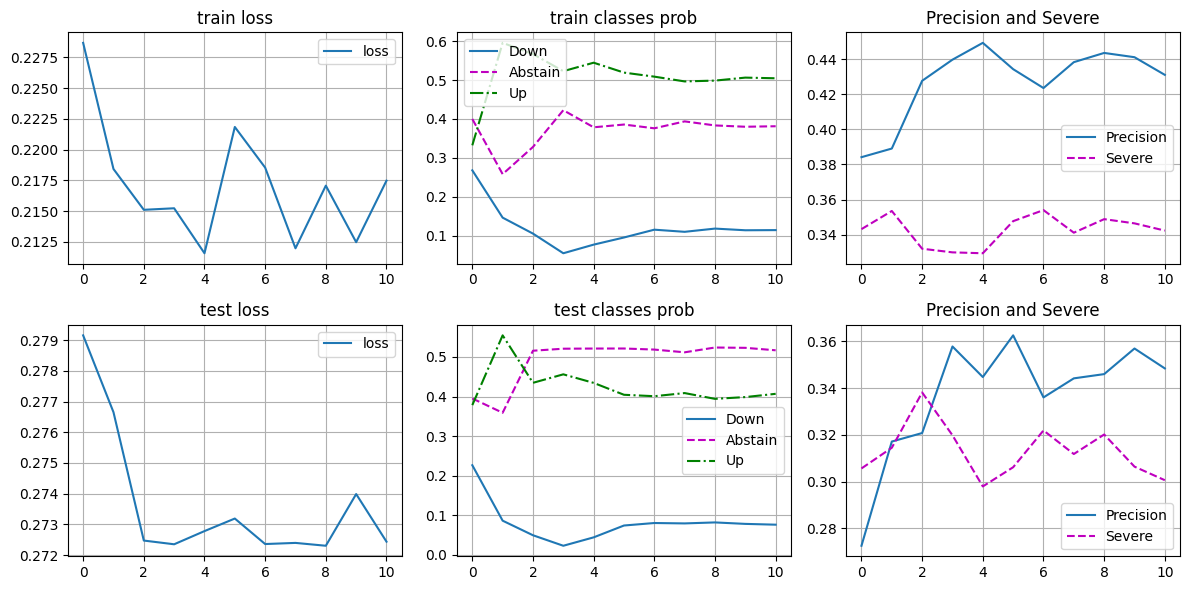

100%|██████████| 100/100 [00:00<00:00, 512.55it/s]


IndexError: list index out of range

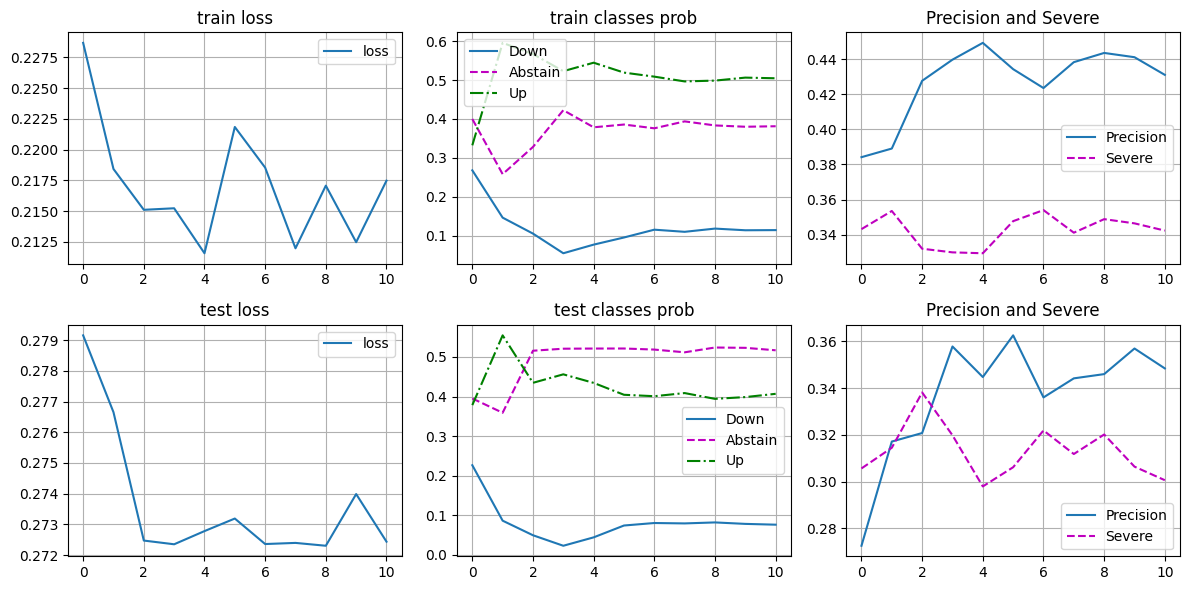

In [ ]:
result = np.zeros(shape = (10, len(assets_list), 4))

for i in range(10):
    validation_start, test_start, test_end = get_random_split(train_ratio, validation_ratio, test_ratio)
    train_set, validation_set, test_set = get_data_set(assets_list, validation_start, test_start, test_end, seq_len, pred_len, threshold_ratio)

    for j in range(len(assets_list)):
        code = assets_list[j]
        train_set_2, validation_set_2, test_set_2 = get_data_set([code], validation_start, test_start, test_end, seq_len, pred_len, threshold_ratio)

        model = Baseline_LSTM(input_size = 5, hidden_size = 10,num_layers = 1, dropout = 0.5).to('cuda:0')
        loss_fn = HybridLoss(alpha = 1e-3, delta = 1)
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay = 1e-1)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
        train = ModelTrain(model = model,
                        batch_size = 100,
                        train_set = train_set,
                        validation_set = validation_set,
                        test_set = test_set,
                        loss_fn = loss_fn,
                        optimizer = optimizer,
                        scheduler=scheduler,
                        recorder=recorder,
                        graph=animator,
                        )
        
        train.train_set = train_set_2
        train.validation_set = validation_set_2

        prediction, precision = train.epoch_train(epochs = 10, round = 100, early_stop = 10)
        result[i,j,0] = prediction
        result[i,j,1] = precision

        # prediction, precision = train.epoch_train(epochs = 10, round = 100, early_stop = 10)
        # result[i,j,2] = prediction
        # result[i,j,3] = precision

In [ ]:
all_assets = pd.DataFrame({
    'stage_1_prediction': np.mean(result, axis = 0)[:,0],
    'stage_2_prediction': np.mean(result, axis = 0)[:,2],

    'stage_1_precision': np.mean(result, axis = 0)[:,1],
    'stage_2_precision': np.mean(result, axis = 0)[:,3],

    'stage_1_precision_std': np.std(result, axis = 0)[:,1],
    'stage_2_precision_std': np.std(result, axis = 0)[:,3],

})

In [ ]:
all_assets_styled = all_assets.style.format({
    'stage_1_prediction': '{:.1%}',
    'stage_1_precision': '{:.1%}',
    'stage_1_precision_std': '{:.1%}',
    'stage_2_prediction': '{:.1%}',
    'stage_2_precision': '{:.1%}',
    'stage_2_precision_std': '{:.1%}',
})
all_assets_styled

In [ ]:
from IPython.display import display, Markdown
display(Markdown(all_assets.to_markdown(index=False)))